# TD 8: Numerical integration of ODEs, and application to the Leaky Integrate-and-Fire neuron model
---

In this tutorial, we will first introduce methods for the numerical integration of differential equations. We will then use those methods to implement a simulation of an Integrate-and-Fire neuron.

## A short introduction to the numerical integration of differential equations

The time evolution of physical systems (planets & membrane voltages) is often described by differential equations, i.e., some equation of the type

$$ \frac{dx}{dt} = f(x, t) $$

When those equations are simple (when $f$ is a simple function), we can solve such equations analytically. An example would be $\dot x = -x/\tau$.

However, it may come in handy to be able to solve such equations numerically, either to check an analytical result or because we haven't been able to fine one (it might not even exist in closed form).



In [1]:
# some imports for the numerics to follow, you'll be familiar with these
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

Let us first plot the analytical solution for the exponential relaxation of the membrane potential $V$ towards the resting potential $E_L$ in the absence of input current. The dynamical equation is given by (see lecture)
$$\frac{dV}{dt} = \frac{1}{\tau_m}(E_L-V),$$
where $\tau_m=C/g_L$ is the membrane time constant. In this example, the membrane potential is our dynamic variable $x$ from the example above, and the right-hand side of the equation corresponds to our function $f(x,t)$.

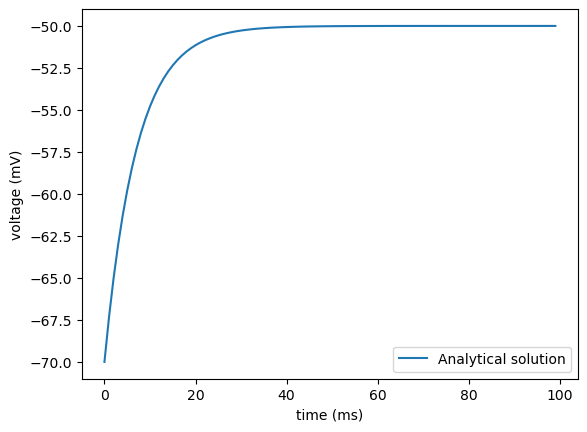

In [2]:
## Decay dynamics

# define parameters
tau = 7.    # decay time constant, in ms
V0 = -70.    # initial voltage, in mV
EL = -50.   # resting potential, in mV

t = np.arange(0, 100)

# This is the right-hand side of the differential equation
# (the time-derivative of v(t); it depends only on the 
# voltage and not on the time t)
def dvdt(v):
    return (EL-v)/tau

# For this simple case, we already know
# the solution of the ODE:
def v_theory(t):
    return (V0-EL)*np.exp(-t/tau) + EL

fig, ax = plt.subplots()
ax.plot(t, v_theory(t), label='Analytical solution')
ax.set_xlabel('time (ms)')
ax.set_ylabel('voltage (mV)')
ax.legend()

Question: can we compute the time course $V(t)$ of the potential by using the ODE?

#### Euler method

A very simple and straightforward method to numerically solve differential equations is the *Euler method*, which relies on the discretization in time of the dynamics and the approximation of the time derivative by a finite difference between subsequent time points:

$$\frac{dx}{dt}\approx\frac{\Delta x}{\Delta t} \ \ \Rightarrow \ \ \Delta x \approx \Delta t \frac{dx}{dt}=\Delta t f(x,t)$$

That is, for $x(t+\Delta t) = x(t) + \Delta x$ we obtain:

$$ x(t+\Delta t) = x(t) + \Delta t f(x,t)$$

In [3]:
# Q: Can you translate the Euler formula into an algorithm?
# A: Yes, the Euler formula prescribes an iterative method, 
#    where we have to compute the solution from one timestep
#    to the next!

# We should define a time step and an integration time:

In [4]:
dt = 0.1
T = 100.
nt = int(T/dt)
t = dt*np.arange(nt)

# An empty array to be filled with the computed values
# of the voltage:
v_euler = np.zeros(nt)

# Implement the initial condition
v_euler[0] = V0

# Our array with the solution BEFORE computing the values
print(v_euler[:10])


[-70.   0.   0.   0.   0.   0.   0.   0.   0.   0.]


In [5]:
# use Euler formula iteratively:
for i in range(nt-1):
    v_euler[i+1] = v_euler[i] + dt * dvdt(v_euler[i])

# Our array with the solution AFTER computing the values
print(v_euler[:10])

[-70.         -69.71428571 -69.43265306 -69.15504373 -68.88140025
 -68.61166596 -68.34578502 -68.08370238 -67.82536377 -67.57071572]


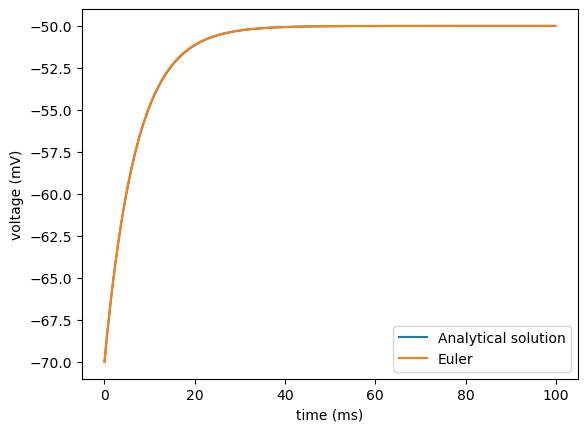

In [6]:
# Plot here the theoretical result 
# together with your numerical solution.

fig, ax = plt.subplots()
ax.plot(t, v_theory(t), label='Analytical solution')
ax.plot(t, v_euler, label='Euler')
ax.set_xlabel('time (ms)')
ax.set_ylabel('voltage (mV)')
ax.legend()

When using the Euler integration method, **the result crucially depends on the time step** used! 

*Question:* How do we know that the result is correct? 

*Answer:* Repeat integration with finer resolution (half the time step) and check for convergence!

In [7]:
# Repeat the above for different time steps and compare.

#### Other methods: using the `scipy` ODE solver

The undeniable advantage of the Euler method is it's simplicity. In many circumstances, one can use much more powerful algorithms; powerful in the sense of better convergence to the true result with respect to the time step used, robustness, etc. However, in almost all practical situations, the easiest option is to use built-in ODE solvers. One such solver is part of the `scipy` python module: `scipy.optimize.odeint` 


In [8]:
# We can use a numerical solver that is already 
# programmed for us!
from scipy.integrate import odeint

In [9]:
# check out the documentation
odeint?

In [10]:
# Can you use odeint to obtain another numerical solution
# for v(t)? 

# For odeint, we have to redefine the derivative function
# (corresponding to f(x,t) above) in such a way that the
# second argument represents the current time!
def dvdt_odeint_safe(v, t):
    return dvdt(v)

# odeint calculates the solution at the times that we pass
# on, and we have to specify the initial condition also:
v_odeint = odeint(dvdt_odeint_safe, V0, t)


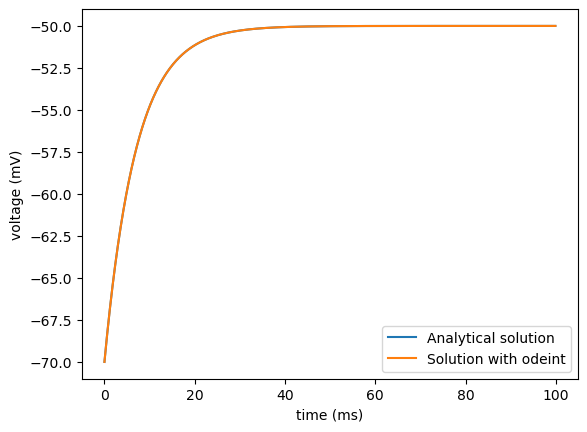

In [11]:
# Plot a comparison of the theoretical and the two
# numerical solutions here.

fig, ax = plt.subplots()
ax.plot(t, v_theory(t), label='Analytical solution')
ax.plot(t, v_odeint, label='Solution with odeint')
ax.set_xlabel('time (ms)')
ax.set_ylabel('voltage (mV)')
ax.legend()

**NOTE:** `scipy.odeint` requires the derivative function to take time as second argument!

## Simulation of a Leaky Integrate-and-Fire neuron

We are now equipped to simulate a LIF neuron for arbitrary input current. Think about which method you would choose to solve the ODE for the membrane potential. Do you have an idea how to implement the threshold condition and the reset?

Also, we have to include now the input current to our Leaky-Integrate-and-Fire neuron:

$$\frac{dV}{dt} = \frac{1}{\tau_m}(E_L-V+I),$$

where for simplicity we rescaled the input current by the input conductance $g_L$ and simply write $I$ with units of $V$.


In [12]:
# We need to redefine the derivative function,
# which for the LIF depends on the input current!
def dvdt(v, I):
    """Derivative of the membrane potential for the 
    LIF. Note that we use I as a short-hand for 
    the input current divided by the leak 
    conductance gL, which has the units of voltage."""
    return (EL+I-v)/tau

# Try to solve the equation for the LIF.
# Start with a constant input current below the firing threshold.

# We have to define a spike threshold voltage and the reset voltage!
Vthreshold = -30. # mV
Vreset = -55.0 # mV

dt = 0.01 # time step in ms
T = 100.0 # duration in ms
t = np.arange(0,T,dt)
nt = len(t)


# ...

In [13]:
# An empty array to be filled with the computed values
# of the voltage:
Ivals = [10, 20, 25] # values for current
vs = []              # list with solutions for different currents 

for i, I in enumerate(Ivals):
    v_euler = np.zeros(nt)

    # Implement the initial condition
    v_euler[0] = Vreset

    # use Euler formula iteratively:
    # --> NOW use current as additional argument to derivative function
    for i in range(nt-1):
        v_euler[i+1] = v_euler[i] + dt * dvdt(v_euler[i], I)
    
    vs.append(v_euler)



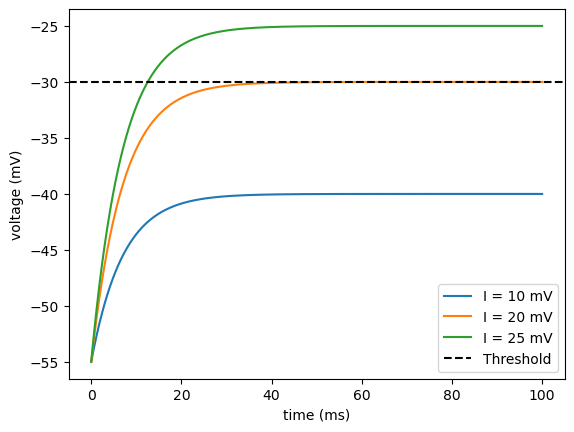

In [14]:
fig, ax = plt.subplots()
for i, I in enumerate(Ivals):
    ax.plot(t, vs[i], label='I = %g mV'%I)
ax.axhline(Vthreshold, c='k', ls='--', label='Threshold')
ax.set_xlabel('time (ms)')
ax.set_ylabel('voltage (mV)')
ax.legend()

We find that for $I>V_{Threshold}-E_L$, the subthreshold dynamics leads to membrane voltage exceeding the threshold!

Of great interest in neuroscience is generally the timing of spikes of individual neurons. The attractivity of Integrate-and-Fire neurons is their possibility to generate such spiketimes in well-controlled settings.

In [15]:
# How does the membrane voltage evolve with a constant input current 
# above the firing threshold?

# When the neuron spikes, add the spiketime to a list:
spiketimes = []
# --> whenever there's a spike at time 'time', do 
spiketimes.append(time)


NameError: name 'time' is not defined

In [16]:
# An empty array to be filled with the computed values
# of the voltage:
Ivals = [21, 22, 25] # values for current
vs = []              # list with solutions for different currents 
spikes = []

for i, I in enumerate(Ivals):
    v_euler = np.zeros(nt)
    spiketimes = []

    # Implement the initial condition
    v_euler[0] = Vreset

    # use Euler formula iteratively:
    # --> NOW use current as additional argument to derivative function
    for i in range(nt-1):
        # subthreshold dynamics...
        v_euler[i+1] = v_euler[i] + dt * dvdt(v_euler[i], I)

        # ...check for threshold crossings!
        if v_euler[i+1] > Vthreshold:
            # we have a spike!
            spiketimes.append(dt*(i+1))
            v_euler[i+1] = Vreset
    
    vs.append(v_euler)
    spikes.append(spiketimes)


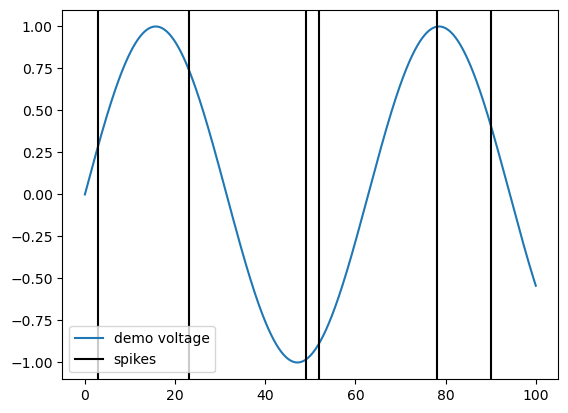

In [17]:
# Plot the membrane potential v(t) together with the spikes
dummytimes = [3, 23, 49, 52, 78, 90]
fig, ax = plt.subplots()
ax.plot(t, np.sin(0.1*t), label='demo voltage')
for time in dummytimes:
    ax.axvline(time, color='k')
ax.plot([],[],'k',label='spikes')
ax.legend()

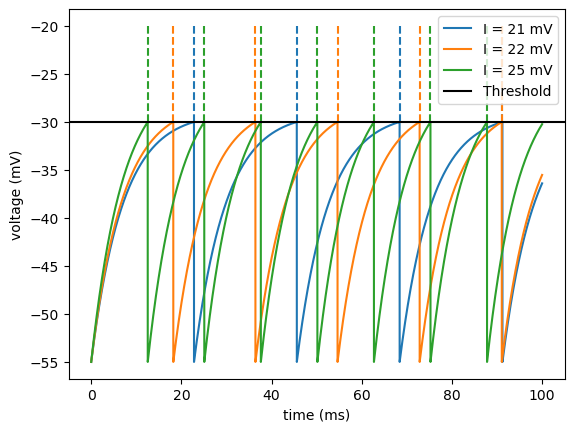

In [18]:
fig, ax = plt.subplots()
for i, I in enumerate(Ivals):
    # plot subthreshold voltage
    ax.plot(t, vs[i], label='I = %g mV'%I)
    # plot spikes (not explicitly modeled, 
    # no real voltage but just marking the time point!)
    col = ax.lines[-1].get_color() # get color of last plotted line
    # plot spikes using 'ax.vlines'
    # (a bit nicer than using 'ax.axvline' actually)
    ax.vlines(spikes[i], ymin=Vthreshold, ymax=Vthreshold+10, color=col, ls='--')
ax.axhline(Vthreshold, c='k', ls='-', label='Threshold')
ax.set_xlabel('time (ms)')
ax.set_ylabel('voltage (mV)')
ax.legend()

We can use our numerical solution of the LIF to check the theoretical prediction of the firing rate, i.e.,

$$f(I) = \frac{1}{\tau_m} \left(\log\frac{E_L+I/g_L-V_{\rm reset}}{E_L+I/g_L-V_{\rm threshold}}\right)^{-1}$$

In [19]:
# Can you calculate the firing rate (the inverse 
# interspike interval, or ISI) for different values
# of the input current?

In [20]:
def fI_theory(I):
    """Firing rate (in Hz) of the LIF as a function 
    of the effective input I/g_L."""
    upper = EL + I -Vreset
    lower = EL + I - Vthreshold
    return 1e3/(tau*np.log(upper/lower))

In [21]:
# calculate the average interspike interval 
# for the spiketrains
f_sim = []

# loop over different input currents 
# (i.e., the spike trains obtained for different currents)
for i, times in enumerate(spikes):
    isis = np.diff(times)
    f_sim.append(1e3/isis.mean())
    
# NOTE that alternatively we could also take the spike count and divide by the 
# length of the simulation --> both are identical at infinitely long simulations
# but the latter is less precise for short simulations
f_sim_alt = [1e3*len(times)/T for times in spikes] 
    

/var/folders/2x/1ky8h5cs7y79x75v9hy67r4r0000gp/T/ipykernel_71332/1030573193.py:6: RuntimeWarning: divide by zero encountered in divide
  return 1e3/(tau*np.log(upper/lower))


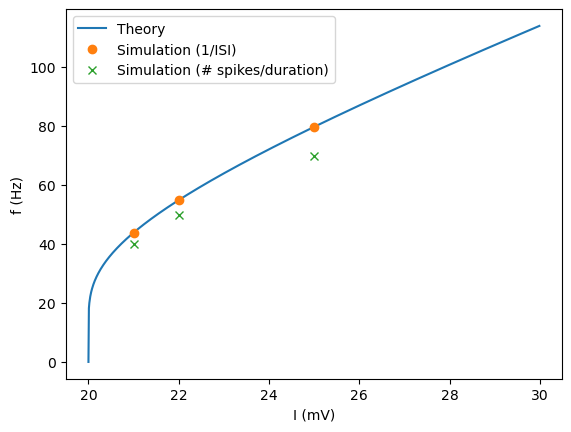

In [22]:
Iarray = np.arange(20,30,0.01)

fig, ax = plt.subplots()
ax.plot(Iarray, fI_theory(Iarray), label='Theory')
ax.plot(Ivals, f_sim, 'o', label='Simulation (1/ISI)')
ax.plot(Ivals, f_sim_alt, 'x', label='Simulation (# spikes/duration)')
ax.set_xlabel('I (mV)')
ax.set_ylabel('f (Hz)')
ax.legend()

### Simulation of a noisy LIF!

Instead of a deterministic, or even constant input current $I(t)$, we now consider a noisy input that represents the combined effect of many presynaptic neurons:

$$I(t) = I_0 + \sigma \xi(t),$$

where $I_0$ is the (constant) mean input, $\sigma$ is a parameter that represents the noise strength, and $\xi(t)$ is a Gaussian stochastic process (normal-distributed) with correlation function $\langle\xi(t)\xi(t')\rangle=\delta(t-t')$. 

In discretized form, the resulting _**stochastic differential equation**_ becomes

$$v_{i+1} = v_i + \Delta t \left[\left(\frac{dv}{dt}\right)_{\rm det}(v_i, t_i) + \sigma\sqrt{\frac{\tau_m}{\Delta t}} \xi_i\right],$$

where $\xi_i$ is now a random number drawn from a normal distribution with zero mean and normalized standard deviation.

-0.5991565913898692


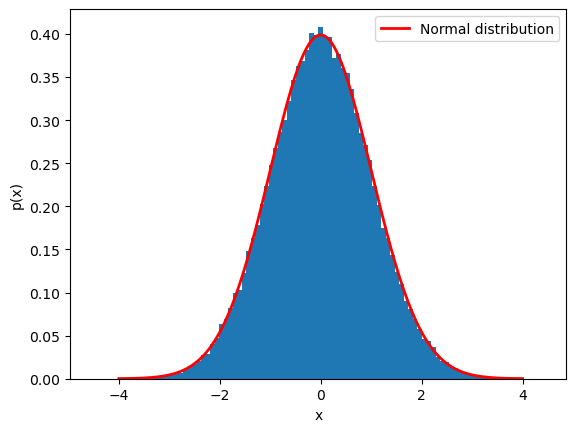

In [23]:
# We get a single random number using
xi = np.random.normal()
print(xi)

# We can check that the histogram of many of 
# of these gives a normal (Gauss) distribution:
fig, ax = plt.subplots()
ax.hist(np.random.normal(size=100000), bins=100, density=True)
x = np.linspace(-4,4,201)
ax.plot(x, np.exp(-x**2/2)/np.sqrt(2*np.pi), 
        color='r',linewidth=2, label='Normal distribution')
ax.set_xlabel('x')
ax.set_ylabel('p(x)')
ax.legend()

In [24]:
# Can you solve the stochastic ODE numerically?
sigma = 0.2

# ...

In [25]:
dt = 0.01 # time step in ms
T = 500.0 # duration in ms
t = np.arange(0,T,dt)
nt = len(t)

# iteration over all times
v_stoch = np.zeros(nt)
v_stoch[0] = Vreset

# choose a mean (average) current
I0 = 19. # mV


# When the neuron spikes, add the spiketime to a list:
spiketimes = []

for i in range(nt-1):
    # Euler integration of subthreshold dynamics: deterministic part
    v_stoch[i+1] = v_stoch[i] + dt*dvdt(v_stoch[i],I0) 

    # Euler integration of subthreshold dynamics: stochastic part
    v_stoch[i+1] += np.sqrt(dt*tau)*sigma*np.random.normal()

    # Spike generation?
    if v_stoch[i+1] > Vthreshold:
        v_stoch[i+1] = Vreset

        # --> whenever there's a spike at time 'time', do 
        spiketimes.append(dt*(i+1))


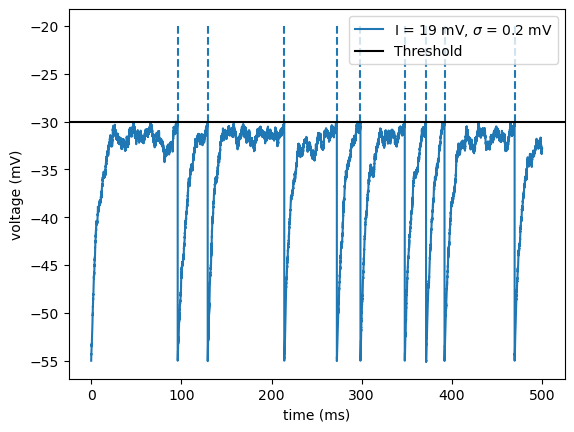

In [26]:
fig, ax = plt.subplots()
# plot subthreshold voltage
ax.plot(t, v_stoch, label='I = %g mV, $\sigma$ = %g mV'%(I0,sigma))
# plot spikes (not explicitly modeled, 
# no real voltage but just marking the time point!)
col = ax.lines[-1].get_color() # get color of last plotted line
# plot spikes using 'ax.vlines'
# (a bit nicer than using 'ax.axvline' actually)
ax.vlines(spiketimes, ymin=Vthreshold, ymax=Vthreshold+10, color=col, ls='--')
ax.axhline(Vthreshold, c='k', ls='-', label='Threshold')
ax.set_xlabel('time (ms)')
ax.set_ylabel('voltage (mV)')
ax.legend()